In [1]:
import os
from autocnet.graph import network
from autocnet.examples import get_path, available
from autocnet.fileio import io_gdal

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Build the graph (This happens in the graph module)

In [2]:
G = network.CandidateGraph()
#Get a list of the available sample data
images = []
for fi in available('Apollo15'):
    d = get_path(fi)
    if '.json' in d:
        continue
    geods = io_gdal.GeoDataSet(get_path(fi))
    G.add_image(os.path.basename(geods.filename), geodataset=geods)
   

adjacency = {'AS15-M-0295_SML.png': [],
 'AS15-M-0296_SML.png':['AS15-M-0297_SML.png', 'AS15-M-0298_SML.png', 'AS15-M-0299_SML.png'],
 'AS15-M-0297_SML.png':['AS15-M-0296_SML.png', 'AS15-M-0298_SML.png', 'AS15-M-0299_SML.png', 'AS15-M-0300_SML.png'],
 'AS15-M-0298_SML.png':['AS15-M-0296_SML.png', 'AS15-M-0297_SML.png', 'AS15-M-0299_SML.png', 'AS15-M-0300_SML.png'],
 'AS15-M-0299_SML.png':['AS15-M-0296_SML.png', 'AS15-M-0297_SML.png', 'AS15-M-0298_SML.png', 'AS15-M-0300_SML.png'],
 'AS15-M-0300_SML.png':['AS15-M-0297_SML.png', 'AS15-M-0298_SML.png', 'AS15-M-0299_SML.png']}

#Add single edges to the graph
basename = 'AS15-M-0{}_SML.png'
for k,v in adjacency.iteritems():
    for i in v:
        G.add_edge(k,i)

/Users/jlaura/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


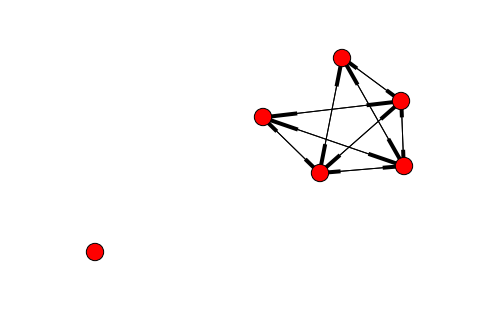

In [3]:
import networkx as nx #Only used to draw

nx.draw(G)
show()

## On to the matching

In [4]:
import cv2
from scipy.misc import bytescale

In [5]:
#Create the sift detector
sift = cv2.xfeatures2d.SIFT_create(10)

In [14]:
#We do not know which pairs might be good, so we need to process all of them.
#This computes for node with incidence 0...
for name, attributes in G.nodes_iter(data=True): #Returns a tuple
    geods = attributes['geodataset']
    #Get the first band of the array and add that data to the attributes
    image_array = bytescale(geods.readarray()) #OpenCV requires that the data be byte scaled...
    attributes['original_image'] = image_array
    keypoints, descriptors = sift.detectAndCompute(image_array, None)
    attributes['keypoints'] = keypoints
    attributes['descriptors'] = descriptors

## FLANN Matching

The idea here is to 'punch through' as many images as possible in a single go.  Basically, take a given image to be the query image, populate a KD-tree with all descriptors in neighbor images and perform the match. 

This will yield $n * k$ matches, where $n$ is the number of descriptors and $k$ is the user defined KNN parameter.

To use Lowe's ratio test, two matches per image are required, where a 'good match' is $i.distance < j.distance * 0.8$.  This requires $k >= node.incidence * 2$

To punch through, book keeping is going to be key.  The example below for three images illustrates how multiple images can be tied.  This is going to be a book keeping / efficiency issue.  By way of example:

296:
  * AS15-M-0297_SML.png 3 3 84.7584838867
  * AS15-M-0298_SML.png 3 6 133.540252686

297:
  * AS15-M-0296_SML.png 3 3 84.7584838867
  * AS15-M-0298_SML.png 3 6 90.1165924072

298:
  * AS15-M-0297_SML.png 6 3 90.1165924072
  * AS15-M-0296_SML.png 6 3 133.540252686

This is the same point, 'punched' through three images.

* How can this best be represented?
  * I need to know:
      * From Image
      * To Image
      * From Image Point ID
      * To Image Point ID
      * Distance
      
This is really the control network - in a raw, unfiltered form.  How best can a control network be represented...
* Assuming a brute force approach to generate this, what is the logic needed to extract this into a control network?

In [ ]:
#This approach generates a new KD-Tree for each node.  What about just using one KD-Tree?
FLANN_INDEX_KDTREE = 1
flann_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
fl = cv2.FlannBasedMatcher(flann_params, {})

for node in ['AS15-M-0296_SML.png','AS15-M-0297_SML.png', 'AS15-M-0298_SML.png']:
    attributes = G.node[node]
    k = len(G.edges(node))
    #k = len(G.edges(node)) * 2 #To support ratio test
    query_descriptor = attributes['descriptors']
    training_descriptors = []

    image_lookup = {}
    for i, n in enumerate(nx.neighbors(G, node)):
        image_lookup[i] = n
        training_descriptors.append(G.node[n]['descriptors'])
    
    fl.add(training_descriptors)
    fl.train()
    
    matches = fl.knnMatch(query_descriptor, k=k)
    clipped_matches = []
    for m_list in matches:
        clipped_m = []
        visited = set()
        for m in m_list:
            if not m.imgIdx in visited:
                visited.add(m.imgIdx)
                clipped_m.append(m)
        clipped_matches.append(clipped_m)

    for c in clipped_matches:
        for i in c:
                print image_lookup[i.imgIdx], i.queryIdx, i.trainIdx, i.distance
        
    fl.clear()
    print

### Performance
The training descriptors are packed into a list using append.  This is inefficient.  If the number of descriptors per image is capped, what about storing an ndarray for efficiency?  Something down the road.

In [19]:
#This example builds a single KD-Tree and then removes self-neighbors
FLANN_INDEX_KDTREE = 1
flann_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
fl = cv2.FlannBasedMatcher(flann_params, {})


training_descriptors = []
image_lookup = {}
#Build a single KD-Tree
for i, n in enumerate(G.nodes()):
    training_descriptors.append(G.node[n]['descriptors'])
    image_lookup[i] = n

fl.add(training_descriptors)
fl.train()

for node in ['AS15-M-0296_SML.png','AS15-M-0297_SML.png', 'AS15-M-0298_SML.png']:
    k = len(G.edges(node)) + 1  #+1 becuase we know a self neighbor will exist.
    query_descriptor = G.node[node]['descriptors']
    
    matches = fl.knnMatch(query_descriptor, k=k)
    clipped_matches = []
    for m_list in matches:
        clipped_m = []
        visited = set()
        for m in m_list:
            if not m.imgIdx in visited and m.distance != 0:
                visited.add(m.imgIdx)
                clipped_m.append(m)
        clipped_matches.append(clipped_m)

    for c in clipped_matches:
        for i in c:
                print image_lookup[i.imgIdx], i.queryIdx, i.trainIdx, i.distance        
    print

AS15-M-0297_SML.png 0 6 85.2173690796
AS15-M-0295_SML.png 0 4 221.366210938
AS15-M-0299_SML.png 0 4 253.791259766
AS15-M-0298_SML.png 1 3 188.647827148
AS15-M-0297_SML.png 1 2 192.278442383
AS15-M-0299_SML.png 2 2 280.540557861
AS15-M-0297_SML.png 2 9 281.609649658
AS15-M-0298_SML.png 2 5 283.871459961
AS15-M-0297_SML.png 3 3 84.7584838867
AS15-M-0295_SML.png 3 8 116.02155304
AS15-M-0298_SML.png 3 6 133.540252686
AS15-M-0297_SML.png 4 7 122.64175415
AS15-M-0298_SML.png 4 4 144.975860596
AS15-M-0295_SML.png 5 0 77.4596633911
AS15-M-0298_SML.png 5 1 126.237869263
AS15-M-0297_SML.png 6 0 50.229473114
AS15-M-0295_SML.png 6 4 87.2410430908
AS15-M-0296_SML.png 6 0 217.926589966
AS15-M-0296_SML.png 7 1 222.274612427
AS15-M-0298_SML.png 7 5 240.185348511
AS15-M-0297_SML.png 7 2 241.240539551
AS15-M-0300_SML.png 8 8 177.203277588
AS15-M-0298_SML.png 8 5 182.677307129
AS15-M-0296_SML.png 8 9 187.741836548
AS15-M-0298_SML.png 9 1 150.552322388
AS15-M-0299_SML.png 9 1 162.28062439

AS15-M-0296_SML